# Model

Tasks:
* (Done) Upload the dataset if not exist
* (Done) Create the training and validation dataset by reading the data in the txt files
* (Done) Resize the flattened data to 3D array
* (Done) Randomly shuffle data and labels from different files in the same order
* (Done) Batch the data then the shape of the data is (2, 32, 32, 3)
* (Issue: a little bit too large for our embedded system) Create an simple model for training
* (Issue: now data type is float32 for training, but our system require tfliteint8, do not know how to solve this yet) Normalize the data to better fit the model
* (Issue: bad acc) Training the network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pathlib
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from os.path import exists
from google.colab import files

In [2]:
BATCH_SIZE = 8
INPUT_HEIGHT = 32
INPUT_WIDTH = 32
INPUT_CHANNEL= 3
NUM_CLASSES = 36

In [3]:
# Upload the dataset if not exist
if not os.path.exists('./keyboard_dataset.tar.gz'):
    uploaded = files.upload()
    # Unzip the dataset
    !tar -xvf keyboard_dataset.tar.gz

Saving keyboard_dataset.tar.gz to keyboard_dataset.tar.gz
Users/xue_q/Downloads/keyboard_dataset/
Users/xue_q/Downloads/keyboard_dataset/test/
Users/xue_q/Downloads/keyboard_dataset/train/
Users/xue_q/Downloads/keyboard_dataset/train/0/
Users/xue_q/Downloads/keyboard_dataset/train/1/
Users/xue_q/Downloads/keyboard_dataset/train/2/
Users/xue_q/Downloads/keyboard_dataset/train/3/
Users/xue_q/Downloads/keyboard_dataset/train/4/
Users/xue_q/Downloads/keyboard_dataset/train/5/
Users/xue_q/Downloads/keyboard_dataset/train/6/
Users/xue_q/Downloads/keyboard_dataset/train/7/
Users/xue_q/Downloads/keyboard_dataset/train/8/
Users/xue_q/Downloads/keyboard_dataset/train/9/
Users/xue_q/Downloads/keyboard_dataset/train/A/
Users/xue_q/Downloads/keyboard_dataset/train/B/
Users/xue_q/Downloads/keyboard_dataset/train/C/
Users/xue_q/Downloads/keyboard_dataset/train/D/
Users/xue_q/Downloads/keyboard_dataset/train/E/
Users/xue_q/Downloads/keyboard_dataset/train/F/
Users/xue_q/Downloads/keyboard_dataset/trai

In [4]:
train_dir = './Users/xue_q/Downloads/keyboard_dataset/train'
train_dir = pathlib.Path(train_dir)
val_dir = './Users/xue_q/Downloads/keyboard_dataset/test'
val_dir = pathlib.Path(val_dir)

train_input_count = len(list(train_dir.glob('*/*.txt')))
val_input_count = len(list(val_dir.glob('*/*.txt')))
print(f'{train_input_count}, {val_input_count}')

144, 36


In [5]:
class_names = np.array([item.name for item in train_dir.glob('*')])
num_classes = len(class_names)
if num_classes != NUM_CLASSES:
  print("Warning: Wrong classes number!")
else:
  print("Good!")
  
print(class_names)
print(num_classes)

Good!
['C' '3' '1' '8' 'X' 'E' '2' 'L' '5' 'M' 'T' 'G' 'O' 'D' 'R' 'U' 'V' 'Z'
 '0' 'H' '4' 'B' 'S' 'N' 'Q' 'J' 'P' 'K' 'Y' 'I' '6' '9' '7' 'F' 'A' 'W']
36


In [6]:
def resize_file_data(data):
  data_flattened = data.split(', ')
  for i in range(0, len(data_flattened)):
    data_flattened[i] = int(data_flattened[i])
  # countOfData = len(data_flattened)
  # print(countOfData)
  data = np.reshape(data_flattened, (INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL))
  # print(data)
  return data

In [47]:
def file_dataset_from_directory(data_path, data_type):
  # Get train, valid and test data from files
  data = []
  label = []
  my_dataset_data = []
  my_dataset_label = []

  # Read the txt files and load the data
  for name in class_names:
    # print(name)
    data_dir = data_path / pathlib.Path(name)
    for filename in os.listdir(data_dir):
      file_dir = os.path.join(data_dir, filename)
      # Checking if it is a file
      if os.path.isfile(file_dir):
          # print(file_dir)
          with open(file_dir, "r") as f:
              content = f.read()
              # print(file_dir)
              content = resize_file_data(content)
              data.append(content)
              # Data and label type should be the same
              # Modify the labels to 0-35
              curr_label = int(ord(name))
              # print(f'the old label of {name} is: {curr_label}')
              if (curr_label > 57):
                curr_label = curr_label - 55
              else:
                curr_label = curr_label - 48
              label.append(curr_label)
              # print(f'the new label of {name} is: {curr_label}')

  # Shuffle the data and label in the same order
  idx = np.random.permutation(len(data))
  data = np.array(data)
  label = np.array(label)
  data_shuffled, label_shuffled = data[idx], label[idx]
  length = len(label_shuffled)
  # print(label)
  # print(label_shuffled)

  # Batch the data by BATCH_SIZE to format 4D tensor as input data
  dataset_len = int(length / BATCH_SIZE)
  # print(f'dataset_len = {dataset_len}')
  for count in range(dataset_len):
    this_data_batch = [None] * BATCH_SIZE
    this_label_batch = [None] * BATCH_SIZE
    for data_num in range(BATCH_SIZE):
      # print(f"data_num = {data_num}")
      data_index = count * BATCH_SIZE + data_num
      # print(f'data_index = {data_index}')
      this_data_batch[data_num] = data_shuffled[data_index]
      # this_data_batch[data_num] = data_shuffled[data_index] / 128
      # this_data_batch[data_num] = this_data_batch[data_num].astype(int)
      this_label_batch[data_num] = label_shuffled[data_index]

    this_data_batch = tf.convert_to_tensor(this_data_batch, dtype=tf.int8)
    # this_data_batch = tf.convert_to_tensor(this_data_batch, dtype=tf.float32)
    this_data_batch = tf.reshape(this_data_batch, [BATCH_SIZE, INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL])
    my_dataset_data.append(this_data_batch)

    this_label_batch = tf.convert_to_tensor(this_label_batch, dtype=tf.int8)
    this_label_batch = tf.reshape(this_label_batch, [BATCH_SIZE])
    my_dataset_label.append(this_label_batch)

  print(data_type + "_total_data_length: " + str(length)) 
  return my_dataset_data, my_dataset_label, length

In [60]:
# Define a simple sequential model
def create_model():
  model = tf.keras.Sequential([
    layers.Conv2D(8, 5, padding='same', activation='relu', input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [48]:
# Load the train and validation dataset
train_data, train_labels, train_len = file_dataset_from_directory(train_dir, "train")
val_data, val_labels, val_len = file_dataset_from_directory(val_dir, "validation")

train_total_data_length: 144
validation_total_data_length: 36


In [49]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

In [61]:
# Create a basic model instance
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 8)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 8, 8, 16)         

In [64]:
epochs = 50
# fit model
his = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/50
18/18 [==============================] - 0s 4ms/step - loss: 3.5541 - accuracy: 0.0556 - val_loss: 3.4421 - val_accuracy: 0.1250
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 3.6323 - accuracy: 0.0278 - val_loss: 3.4245 - val_accuracy: 0.1250
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 3.4458 - accuracy: 0.0694 - val_loss: 3.4069 - val_accuracy: 0.1250
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 3.4513 - accuracy: 0.0833 - val_loss: 3.3704 - val_accuracy: 0.1562
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 3.4610 - accuracy: 0.0764 - val_loss: 3.3705 - val_accuracy: 0.1250
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 3.4289 - accuracy: 0.0556 - val_loss: 3.3669 - val_accuracy: 0.2188
Epoch 7/50
18/18 [==============================] - 0s 4ms/step - loss: 3.1853 - accuracy: 0.1319 - val_loss: 3.3323 - val_accuracy: 0.1875
Epoch 8/50
18/18 [==

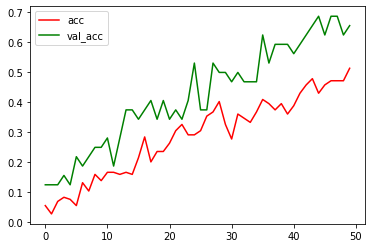

In [65]:
plt.plot(his.history['accuracy'], label='acc', color='red')
plt.plot(his.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

In [53]:
# Save the entire model as a SavedModel.
model.save('weight.h5')

In [54]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [55]:
!xxd -i model.tflite > model_data.cc

# Utilities

In [ ]:
temp = '-128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 11, -12, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -40, 39, -128, -34, 33, -128, -28, 27, -128, -22, 21, -128, -128, -128, -128, -128, 53, -54, -128, -48, 47, -128, -78, 77, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -52, 51, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 65, -66, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -64, 63, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 121, -122, -128, -128, 71, -72, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -70, 69, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 83, -84, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -76, 75, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -88, 87, -128, -82, 81, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 89, -90, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -94, 93, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 95, -96, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -100, 99, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 101, -102, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -106, 105, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, 107, -108, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -112, 111, -128, -128, -128, -128, -128, -128, -128, -128, 113, -114, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -118, 117, -128, -124, 123, -128, -128, -128, -128, -128, 119, -120, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -118, 117, -128, -128, 125, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128'
temp_data = temp.split(', ')
for i in range(0, len(temp_data)):
    temp_data[i] = int(temp_data[i])
countOfWords = len(temp_data)
print(temp_data)
print(countOfWords)
temp_data = np.resize(temp_data, (input_height, input_width, input_channel))
print(temp_data)

In [35]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
num_classes = len(class_names)
print(num_classes)

36


In [40]:
for curr in train_ds:
  print(curr)
  break

(<tf.Tensor: shape=(8, 32, 32, 3), dtype=int8, numpy=
array([[[[-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128],
         ...,
         [-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128]],

        [[-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128],
         ...,
         [-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128]],

        [[-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128],
         ...,
         [-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128]],

        ...,

        [[-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128],
         ...,
         [-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128]],

        [[-128, -128, -128],
         [-128, -128, -128],
         [-128, -128, -128],
         ...,
         [-128, -128, -128],
         [-128, -128, -128],
         [-12

In [20]:
def create_model():
  model = tf.keras.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNEL)),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

  return model